In [92]:
import os
import json
from collections import defaultdict
from packaging.version import parse as parse_version
import warnings
warnings.filterwarnings('ignore')

import cv2 
import imageio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu, tanh, elu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds
from tensorflow_addons.layers import InstanceNormalization

from keras.utils import plot_model

print("Tensorflow", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


Tensorflow 2.12.0
GPU is available


In [93]:
image_shape = (256, 256, 3)
IMG_HEIGHT = image_shape[0]
IMG_WIDTH = image_shape[1]

In [94]:
t1 = "../res/fakebbtrain_900/" # fake train
t2 = "../res/realbbtrain_590/" # real train
t3 = "../res/fakebbtest/" # fake test
t4 = "../res/realbbtest/" # real test

In [95]:
# list of images
t1_images = [t1 + i for i in os.listdir(t1)]
t2_images = [t2 + i for i in os.listdir(t2)]
t3_images = [t3 + i for i in os.listdir(t3)]
t4_images = [t4 + i for i in os.listdir(t4)]

In [96]:
# Images count for each category
print("\n\nTotal Images in each category:\n")
print(f"t1: {len(t1_images)}")
print(f"t2: {len(t2_images)}")
print(f"t3: {len(t3_images)}")
print(f"t4: {len(t4_images)}")



Total Images in each category:

t1: 900
t2: 590
t3: 75
t4: 20




Sample Training Images from each category:



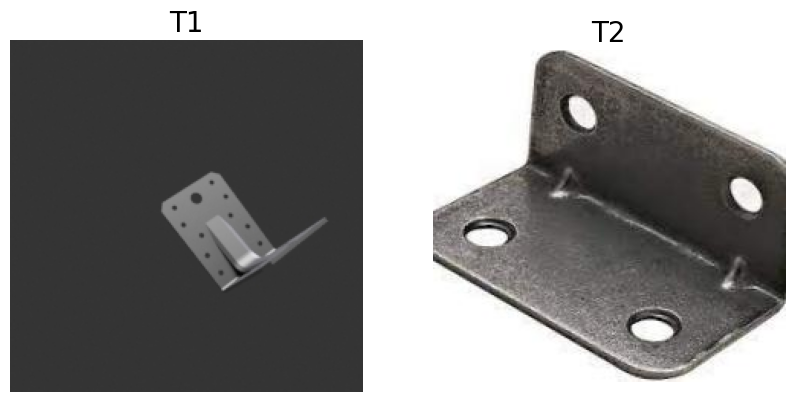

In [97]:
# Priting sample images from each category
print("\n\nSample Training Images from each category:\n")
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(t1_images[5]))
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(t2_images[2]))
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()



Sample Test Images from each category:



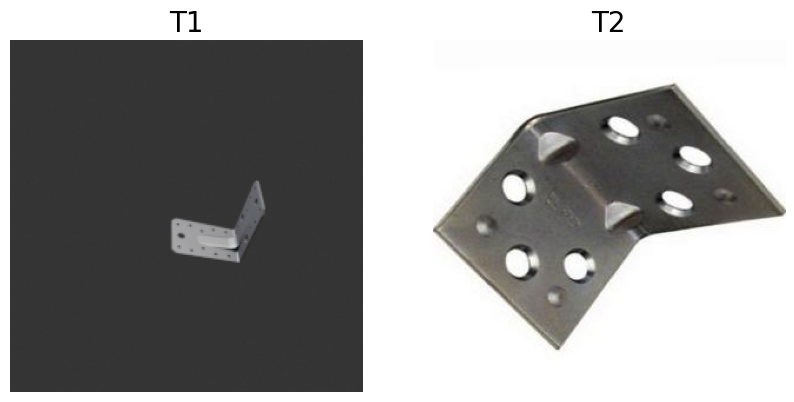

In [98]:
# Priting sample images from each category
print("\n\nSample Test Images from each category:\n")
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(t3_images[5]))
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(t4_images[10]))
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()

In [99]:
# function to load images and resize
def load_images(img_list):
    img_arr = []
    for img in img_list:
        img = Image.open(img)
        img_arr.append(np.array(img))
    return np.array(img_arr)

In [100]:
t1_images = load_images(t1_images)
t2_images = load_images(t2_images)
t3_images = load_images(t3_images)
t4_images = load_images(t4_images)

In [101]:
# Function to resize real images to 124x124
def image_resize(imglist,x,y):
  t2_images_resize = []
  for img in imglist:
    resize_image = cv2.resize(img, (y, x))
    t2_images_resize.append(np.array(resize_image))
  return np.array(t2_images_resize)

In [102]:
t2_images = image_resize(t2_images,256,256)
t4_images = image_resize(t4_images,256,256)

In [103]:
# Get a list of all image files in the folder
image_files_train = [f for f in os.listdir(t1) if f.endswith('.jpg')]
print(type(image_files_train))
image_files_test = [f for f in os.listdir(t3) if f.endswith('.jpg')]
print(type(image_files_test))

<class 'list'>
<class 'list'>


In [104]:
# load the COCO annotation  file for training images
path_train = '../annotations/coco_annotations_train.json'
path_test = '../annotations/coco_annotations_test.json'
file_train = open(path_train)
file_test = open(path_test)
coco_data_train = json.load(file_train)
coco_data_test = json.load(file_test)

In [105]:
mylist1_id_train = []
mylist2_box_train = []
# Add info datastructure
for annotation in coco_data_train['annotations']:
  image_ids, bounding_box = annotation['image_id'], annotation['bbox']
  mylist1_id_train.append(image_ids)
  mylist2_box_train.append(bounding_box)

final_list_train = [item for pair in zip(mylist1_id_train, mylist2_box_train) for item in pair]

In [106]:
mylist1_id_test = []
mylist2_box_test = []
# Add info datastructure
for annotation in coco_data_test['annotations']:
  image_ids, bounding_box = annotation['image_id'], annotation['bbox']
  mylist1_id_test.append(image_ids)
  mylist2_box_test.append(bounding_box)

final_list_test = [item for pair in zip(mylist1_id_test, mylist2_box_test) for item in pair]

In [107]:
image_id_list_train = []

for i, image in enumerate(t1_images):
    filename = image_files_train[i]
    image_id_str = filename.split("/")[-1].split(".")[0]  # Extract the relevant part

    # Now, remove any non-numeric characters from image_id_str
    image_id_str = ''.join(filter(str.isdigit, image_id_str))
    image_id = int(image_id_str)  # Convert the cleaned string to an integer

    # Append the image_id to the list
    image_id_list_train.append(image_id)

In [108]:
image_id_list_test = []

for j, image in enumerate(t3_images):
    filename = image_files_test[j]
    image_id_str = filename.split("/")[-1].split(".")[0]  # Extract the relevant part

    # Now, remove any non-numeric characters from image_id_str
    image_id_str = ''.join(filter(str.isdigit, image_id_str))
    image_id = int(image_id_str)  # Convert the cleaned string to an integer

    # Append the image_id to the list
    image_id_list_test.append(image_id)

In [109]:
bb_list_train = []
for item in image_id_list_train:
  if (item in final_list_train):
    index = final_list_train.index(item)
    var = final_list_train[index+1]
    bb_list_train.append(var)

In [110]:
bb_list_test = []
for item in image_id_list_test:
  if (item in final_list_test):
    index = final_list_test.index(item)
    var = final_list_test[index+1]
    bb_list_test.append(var)

In [111]:
# Create a function to crop an image based on a bounding box
def crop_image(image, bbox):

  # Convert the NumPy array to a Pillow image
    image = Image.fromarray(image)
    # Extract bounding box coordinates
    x, y, w, h = bbox

    # Crop the image using tf.image.crop_to_bounding_box
    cropped_image = image.crop((x, y, x + w, y + h))

    return cropped_image

In [112]:
# Create a list to store the cropped images
cropped_images_train = []

# Iterate through the images and bounding boxes
for image, bbox in zip(t1_images, bb_list_train):
    cropped_image = crop_image(image, bbox)
    cropped_images_train.append(cropped_image)

In [113]:
# Create a list to store the cropped images
cropped_images_test = []

# Iterate through the images and bounding boxes
for image, bbox in zip(t3_images, bb_list_test):
    cropped_image = crop_image(image, bbox)
    cropped_images_test.append(cropped_image)

In [114]:
def load_cropped_images(img_list):
    img_arr = []
    for img in img_list:
        img_arr.append(np.array(img))  # Convert to NumPy array and append to the list
    return np.array(img_arr)  # Convert the list to a NumPy ndarray

In [115]:
def sharpen_images(img_list):
    img_arr = []
    for img in img_list:
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        image_sharp = cv2.filter2D(img, ddepth=-1, kernel=kernel)
        deblurred_image = cv2.GaussianBlur(image_sharp, (1, 1), 0)
        img_arr.append(np.array(deblurred_image))  # Convert to NumPy array and append to the list
    return np.array(img_arr)  # Convert the list to a NumPy ndarray

In [116]:
t1_images = load_cropped_images(cropped_images_train)
t1_images = image_resize(t1_images,256,256)
t1_images = sharpen_images(t1_images)

In [117]:
t3_images = load_cropped_images(cropped_images_test)
t3_images = image_resize(t3_images,256,256)
t3_images = sharpen_images(t3_images)

In [118]:
# information of training dataset
print("\n\nInformation of dataset:\n")
print(f"t1: {t1_images.shape}")
print(f"t2: {t2_images.shape}")



Information of dataset:

t1: (900, 256, 256, 3)
t2: (590, 256, 256, 3)


In [119]:
# information of test dataset
print("\n\nInformation of dataset:\n")
print(f"t1: {t3_images.shape}")
print(f"t2: {t4_images.shape}")



Information of dataset:

t1: (75, 256, 256, 3)
t2: (20, 256, 256, 3)


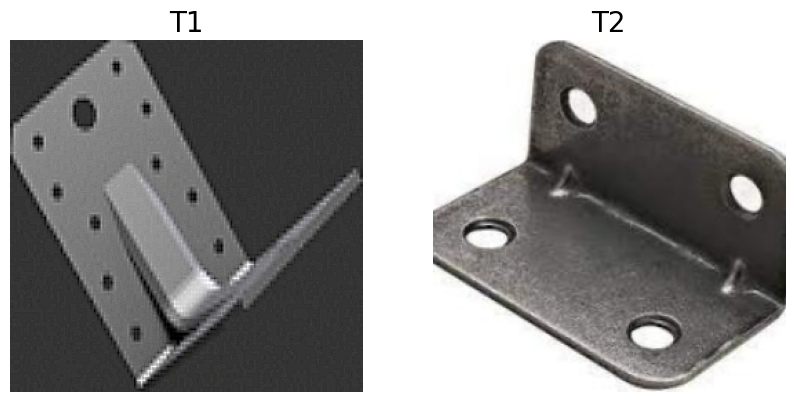

In [120]:
# Printing sample images from each category after preprocessing
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(t1_images[5])
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(t2_images[2])
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()

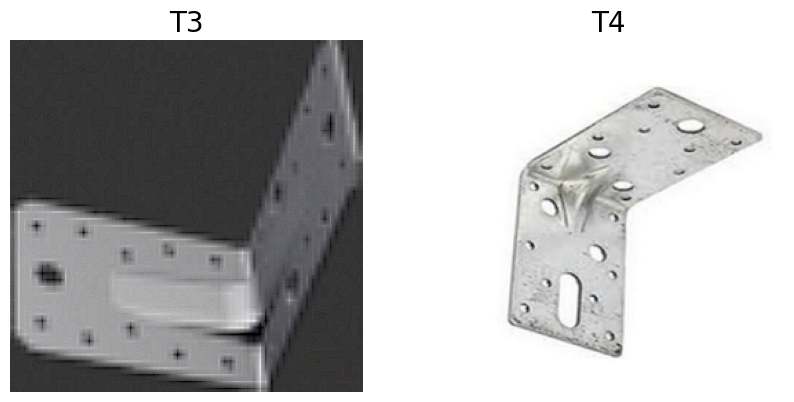

In [121]:
# Printing sample images from each category after preprocessing
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(t3_images[5])
plt.title("T3", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(t4_images[2])
plt.title("T4", fontsize=20)
plt.axis("off")
plt.show()

In [122]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

In [123]:
def preprocess_images(img):
    img = tf.image.random_flip_left_right(img)
    #img = tf.image.resize(img, [*(img_height, img_width)])
    #img = tf.image.random_crop(img, size=[*(img_height, img_width, 1)])
    img = normalize_img(img)
    return img

In [124]:
t1_images = [preprocess_images(image) for image in t1_images]
t2_images = [preprocess_images(image) for image in t2_images]
t3_images = [preprocess_images(image) for image in t3_images]
t4_images = [preprocess_images(image) for image in t4_images]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].


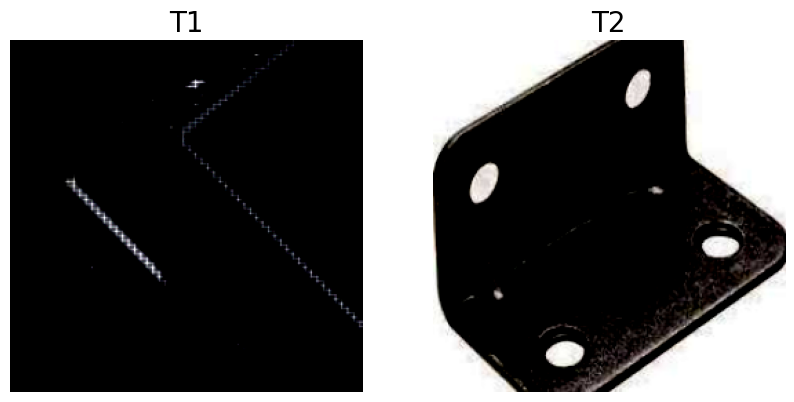

In [125]:
# Printing sample images from each category after preprocessing
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(t1_images[12],cmap="gray")
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(t2_images[6],cmap="gray")
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


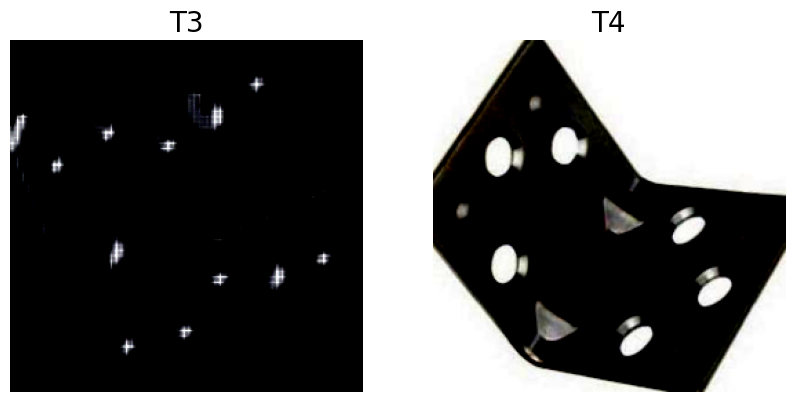

In [126]:
# Printing sample images from each category after preprocessing
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(t3_images[12],cmap="gray")
plt.title("T3", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(t4_images[6],cmap="gray")
plt.title("T4", fontsize=20)
plt.axis("off")
plt.show()

In [127]:
from tensorflow import keras
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 128
batch_size = 1

In [128]:
def create_dataset(images, buffer_size, batch_size):
    return (
        tf.data.Dataset.from_tensor_slices(images)
        .cache()
        .shuffle(buffer_size)
        .batch(batch_size)
    )

In [129]:
# Create datasets
t1_dataset = create_dataset(t1_images, buffer_size, batch_size)
t2_dataset = create_dataset(t2_images, buffer_size, batch_size)
t3_dataset = create_dataset(t3_images, buffer_size, batch_size)
t4_dataset = create_dataset(t4_images, buffer_size, batch_size)

In [131]:
# Define custom directory for saving datasets
custom_dir = '../tf_datasets'
os.makedirs(custom_dir, exist_ok=True)

In [133]:
# Save the datasets to the custom directory
tf.data.experimental.save(t1_dataset, os.path.join(custom_dir, 't1_dataset'))
tf.data.experimental.save(t2_dataset, os.path.join(custom_dir, 't2_dataset'))
tf.data.experimental.save(t3_dataset, os.path.join(custom_dir, 't3_dataset'))
tf.data.experimental.save(t4_dataset, os.path.join(custom_dir, 't4_dataset'))

2024-08-06 16:01:55.404755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [900,256,256,3]
	 [[{{node Placeholder/_0}}]]
2024-08-06 16:01:55.404980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [900,256,256,3]
	 [[{{node Placeholder/_0}}]]
2024-08-06 16:01:56.225660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float 

In [134]:
# Save the dataset specifications
specs = {
    't1_spec': t1_dataset.element_spec,
    't2_spec': t2_dataset.element_spec,
    't3_spec': t3_dataset.element_spec,
    't4_spec': t4_dataset.element_spec
}

np.save(os.path.join(custom_dir, 'dataset_specs.npy'), specs)

print("Datasets saved to custom directory:", custom_dir)

Datasets saved to custom directory: ../tf_datasets
